In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


from sklearn.neighbors import KNeighborsClassifier

In [2]:
#cargamos el archivo
ruta_fichero = 'C:/Users/guillermo/Desktop/IA/datos_meteorologicos_SELECTED_ATRIBUTES.csv'
fichero = pd.read_csv(ruta_fichero)

In [3]:
# Modificar el dataset
# Reemplazar 'Ip' y convertir 'prec' a float
fichero['prec'] = fichero['prec'].replace('Ip', '0.1').str.replace(',', '.').astype(float)

In [4]:
# Creamos la columna 'lluvia' para saber claramente si llovió o no
fichero['lluvia'] = fichero['prec'] != 0.0
''''para cada fila en el DataFrame, si el valor en la columna 'prec'
es diferente de 0.0, la columna 'lluvia' para esa fila tendrá el valor True
indicando que ha llovido. Si el valor en 'prec' es 0.0, entonces 'lluvia' será False, indicando que no ha llovido'''

"'para cada fila en el DataFrame, si el valor en la columna 'prec'\nes diferente de 0.0, la columna 'lluvia' para esa fila tendrá el valor True\nindicando que ha llovido. Si el valor en 'prec' es 0.0, entonces 'lluvia' será False, indicando que no ha llovido"

In [5]:
# Guardamos el dataset modificado
nombre_archivo = 'datos_meteorologicos_modificados.csv'
fichero.to_csv(nombre_archivo, index=False)

In [6]:
fichero.drop('prec', axis=1, inplace=True)


In [7]:
# Para múltiples columnas
columnas_a_corregir = ['tmed', 'tmin','tmax','velmedia','racha','presMax','presMin']
for col in columnas_a_corregir:
    fichero[col] = fichero[col].str.replace(',', '.').astype(float)


# KNN

In [8]:
print(fichero.columns)

Index(['altitud', 'tmed', 'tmin', 'tmax', 'dir', 'velmedia', 'racha',
       'presMax', 'presMin', 'lluvia'],
      dtype='object')


In [9]:
X = fichero.drop('lluvia', axis=1)  # Features
y = fichero['lluvia']  # Variable de salida

# División en 80/20 para entrenamiento y val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear conjuntos de entrenamiento y prueba
conjunto_train = pd.concat([X_train, y_train], axis=1)
conjunto_val = pd.concat([X_val, y_val], axis=1)


# Creamos dos conjuntos para poner las predicciones del train y test
conjunto_train_eval = conjunto_train.copy()
conjunto_validation_eval = conjunto_val.copy()

In [10]:
precision_train = {}#Este diccionario se utilizará para guardar los valores de precisión del modelo en el conjunto de entrenamiento.
precision_val = {}#este diccionario está destinado a almacenar los valores de precisión del modelo en el conjunto de validación

##  TRAIN con un tuneLength 10

In [11]:
# Definir los parámetros que deseas ajustar
param_grid = {'kneighborsclassifier__n_neighbors': list(range(1, 11))}

# Establecer la semilla para reproducibilidad
np.random.seed(150)

In [12]:
# Crear un imputador que reemplaza NaN por la media
imputador = SimpleImputer(strategy='mean')

In [13]:
# Definir el modelo KNN
knn_model = KNeighborsClassifier()

pipeline = make_pipeline(StandardScaler(),imputador, knn_model)

# Método de control (k-fold cross-validation)
metodo_control_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Entrenar el modelo con GridSearchCV para ajustar los hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, scoring=make_scorer(accuracy_score), cv=metodo_control_cv)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

In [14]:
# Imprimir resultados
print("Mejor modelo:", best_model)

Mejor modelo: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])


In [15]:
# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
confusion_mat_train = confusion_matrix(y_train, y_train_pred)

# Imprimir la matriz de confusión y la precisión en el conjunto de entrenamiento
print("Matriz de Confusión (Train):")
print(confusion_mat_train)

Matriz de Confusión (Train):
[[3132  474]
 [ 505 1965]]


In [16]:
print("Precisión en el conjunto de entrenamiento:", accuracy_train)

precision_train['knn_tuneLength_10'] = accuracy_train

Precisión en el conjunto de entrenamiento: 0.8388742593811718


In [17]:
# Obtener los resultados del grid search
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Imprimir información sobre el proceso de búsqueda
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada (Accuracy):", grid_search.best_score_)

Mejores parámetros: {'kneighborsclassifier__n_neighbors': 7}
Mejor puntuación de validación cruzada (Accuracy): 0.7837412208445331


In [18]:
# Imprimir resultados de cada conjunto de parámetros
print(resultados_df[['params', 'mean_test_score']])

                                      params  mean_test_score
0   {'kneighborsclassifier__n_neighbors': 1}         0.758065
1   {'kneighborsclassifier__n_neighbors': 2}         0.750822
2   {'kneighborsclassifier__n_neighbors': 3}         0.767610
3   {'kneighborsclassifier__n_neighbors': 4}         0.758886
4   {'kneighborsclassifier__n_neighbors': 5}         0.777485
5   {'kneighborsclassifier__n_neighbors': 6}         0.774027
6   {'kneighborsclassifier__n_neighbors': 7}         0.783741
7   {'kneighborsclassifier__n_neighbors': 8}         0.777648
8   {'kneighborsclassifier__n_neighbors': 9}         0.782916
9  {'kneighborsclassifier__n_neighbors': 10}         0.783410


In [19]:
# Crear un pipeline con escalado y clasificador KNN
model = make_pipeline(StandardScaler(),imputador, KNeighborsClassifier())

# Lista para almacenar las puntuaciones de accuracy en cada fold y para cada conjunto de parámetros
accuracy_scores = []

# Realizar la validación cruzada
for fold, (train_idx, val_idx) in enumerate(metodo_control_cv.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    print(f"\nFold {fold + 1}:")

    for params in param_grid.values():
        for param_value in params:
            # Crear un modelo con el valor actual del parámetro
            model.set_params(kneighborsclassifier__n_neighbors=param_value)

            # Entrenar el modelo
            model.fit(X_train_fold, y_train_fold)

            # Evaluar el modelo en el conjunto de validación
            accuracy = model.score(X_val_fold, y_val_fold)

            # Imprimir la puntuación de accuracy para el valor actual del parámetro
            print(f"   {list(param_grid.keys())[0]}={param_value}, Accuracy={accuracy}")

            # Almacenar la puntuación de accuracy
            accuracy_scores.append({'Fold': fold + 1, list(param_grid.keys())[0]: param_value, 'Accuracy': accuracy})




Fold 1:
   kneighborsclassifier__n_neighbors=1, Accuracy=0.775
   kneighborsclassifier__n_neighbors=2, Accuracy=0.7486842105263158
   kneighborsclassifier__n_neighbors=3, Accuracy=0.7881578947368421
   kneighborsclassifier__n_neighbors=4, Accuracy=0.781578947368421
   kneighborsclassifier__n_neighbors=5, Accuracy=0.8
   kneighborsclassifier__n_neighbors=6, Accuracy=0.7960526315789473
   kneighborsclassifier__n_neighbors=7, Accuracy=0.8
   kneighborsclassifier__n_neighbors=8, Accuracy=0.8026315789473685
   kneighborsclassifier__n_neighbors=9, Accuracy=0.7986842105263158
   kneighborsclassifier__n_neighbors=10, Accuracy=0.7934210526315789

Fold 2:
   kneighborsclassifier__n_neighbors=1, Accuracy=0.7723684210526316
   kneighborsclassifier__n_neighbors=2, Accuracy=0.7605263157894737
   kneighborsclassifier__n_neighbors=3, Accuracy=0.7776315789473685
   kneighborsclassifier__n_neighbors=4, Accuracy=0.7552631578947369
   kneighborsclassifier__n_neighbors=5, Accuracy=0.7684210526315789
   kn

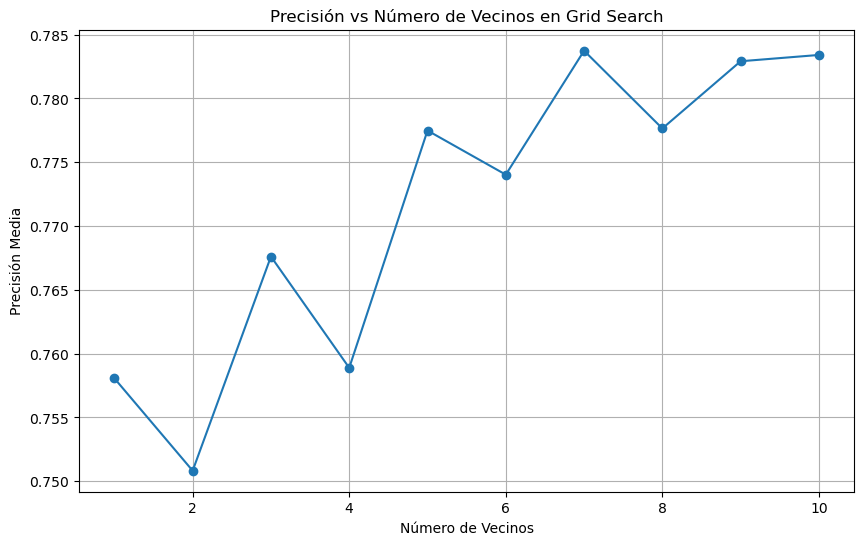

In [20]:
# Extraer los resultados del Grid Search
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Obtener los valores relevantes
parametros = resultados_df['param_kneighborsclassifier__n_neighbors']
precision_media = resultados_df['mean_test_score']

# Graficar la precisión en función del número de vecinos
plt.figure(figsize=(10, 6))
plt.plot(parametros, precision_media, marker='o')
plt.title('Precisión vs Número de Vecinos en Grid Search')
plt.xlabel('Número de Vecinos')
plt.ylabel('Precisión Media')
plt.grid(True)
plt.show()

In [21]:
print(conjunto_train_eval.columns)
print(conjunto_validation_eval.columns)

Index(['altitud', 'tmed', 'tmin', 'tmax', 'dir', 'velmedia', 'racha',
       'presMax', 'presMin', 'lluvia'],
      dtype='object')
Index(['altitud', 'tmed', 'tmin', 'tmax', 'dir', 'velmedia', 'racha',
       'presMax', 'presMin', 'lluvia'],
      dtype='object')


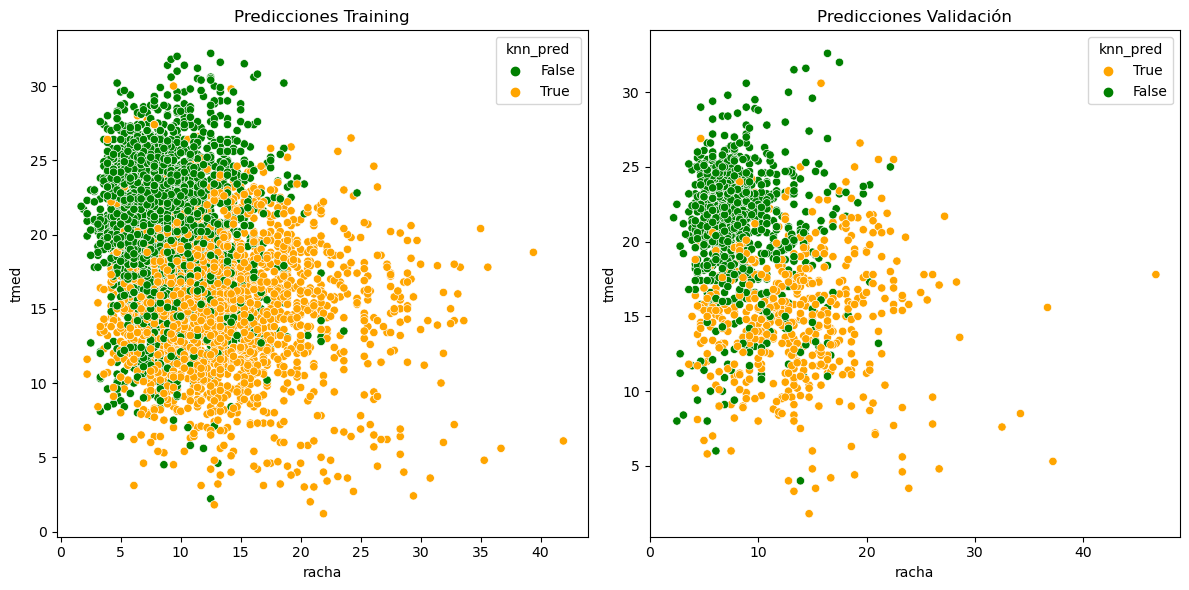

In [22]:
# Evaluación del modelo
# Training
conjunto_train_eval['knn_prob'] = best_model.predict_proba(X_train)[:, 1]
conjunto_train_eval['knn_pred'] = best_model.predict(X_train).astype(str)  # Asegúrate de que knn_pred sea de tipo str

# Test
conjunto_validation_eval['knn_prob'] = best_model.predict_proba(X_val)[:, 1]
conjunto_validation_eval['knn_pred'] = best_model.predict(X_val).astype(str)  # Asegúrate de que knn_pred sea de tipo str

# Asignar colores específicos a cada clase
# Asegúrate de que 'YES' y 'NO' correspondan a cómo se representan las clases en 'knn_pred'
palette = {'False': 'green', 'True': 'orange'}

plt.figure(figsize=(12, 6))

# Primer subplot para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
sns.scatterplot(x='racha', y='tmed', hue='knn_pred', data=conjunto_train_eval, palette=palette)
plt.title('Predicciones Training')

# Segundo subplot para el conjunto de validación
plt.subplot(1, 2, 2)
sns.scatterplot(x='racha', y='tmed', hue='knn_pred', data=conjunto_validation_eval, palette=palette)
plt.title('Predicciones Validación')

plt.tight_layout()  # Ajusta la disposición para que no haya superposición de gráficos
plt.show()


## Validacion

In [23]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de validación
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
confusion_mat = confusion_matrix(y_val, y_pred)

# Imprimir la matriz de confusión y la precisión en el conjunto de validación
print("Matriz de Confusión:")
print(confusion_mat)

Matriz de Confusión:
[[760 146]
 [172 442]]


In [24]:
print("Precisión en el conjunto de validación:", accuracy)
precision_val['knn_tuneLength_10'] = accuracy

Precisión en el conjunto de validación: 0.7907894736842105


## Train con un grid (1,21,2)

In [25]:
# Definir el modelo KNN y el imputador
knn_model = KNeighborsClassifier()

# Crear un pipeline con el imputador, el escalador y el clasificador KNN
model = Pipeline([
    ('imputador', imputador),
    ('scaler', StandardScaler()),
    ('knn', knn_model)
])

# Definir los parámetros que deseas ajustar
param_grid = {'knn__n_neighbors': np.arange(1, 121, 2)}  #1 3 5 ... hasta 117

# Establecer la semilla para reproducibilidad
np.random.seed(150)

# Entrenar el modelo con GridSearchCV para ajustar los hiperparámetros
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=metodo_control_cv)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Imprimir resultados
print("Mejor modelo:", best_model)



Mejor modelo: Pipeline(steps=[('imputador', SimpleImputer()), ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=35))])


In [26]:
# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
confusion_mat_train = confusion_matrix(y_train, y_train_pred)

# Imprimir la matriz de confusión y la precisión en el conjunto de entrenamiento
print("Matriz de Confusión (Train):")
print(confusion_mat_train)

Matriz de Confusión (Train):
[[2993  613]
 [ 627 1843]]


In [27]:
print("Precisión en el conjunto de entrenamiento:", accuracy_train)
precision_train['knn_tuneGrid'] = accuracy_train

Precisión en el conjunto de entrenamiento: 0.7959183673469388


In [28]:
# Obtener los resultados del grid search
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Imprimir información sobre el proceso de búsqueda
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada (Accuracy):", grid_search.best_score_)

Mejores parámetros: {'knn__n_neighbors': 35}
Mejor puntuación de validación cruzada (Accuracy): 0.7896620025145235


In [29]:
# Imprimir resultados de cada conjunto de parámetros
print(resultados_df[['params', 'mean_test_score']])

                       params  mean_test_score
0     {'knn__n_neighbors': 1}         0.759380
1     {'knn__n_neighbors': 3}         0.769092
2     {'knn__n_neighbors': 5}         0.776989
3     {'knn__n_neighbors': 7}         0.782260
4     {'knn__n_neighbors': 9}         0.784068
5    {'knn__n_neighbors': 11}         0.784894
6    {'knn__n_neighbors': 13}         0.785549
7    {'knn__n_neighbors': 15}         0.785055
8    {'knn__n_neighbors': 17}         0.783740
9    {'knn__n_neighbors': 19}         0.783574
10   {'knn__n_neighbors': 21}         0.784891
11   {'knn__n_neighbors': 23}         0.783904
12   {'knn__n_neighbors': 25}         0.784230
13   {'knn__n_neighbors': 27}         0.786697
14   {'knn__n_neighbors': 29}         0.785383
15   {'knn__n_neighbors': 31}         0.785383
16   {'knn__n_neighbors': 33}         0.786865
17   {'knn__n_neighbors': 35}         0.789662
18   {'knn__n_neighbors': 37}         0.787522
19   {'knn__n_neighbors': 39}         0.787027
20   {'knn__n

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_knn__n_neighbors', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')


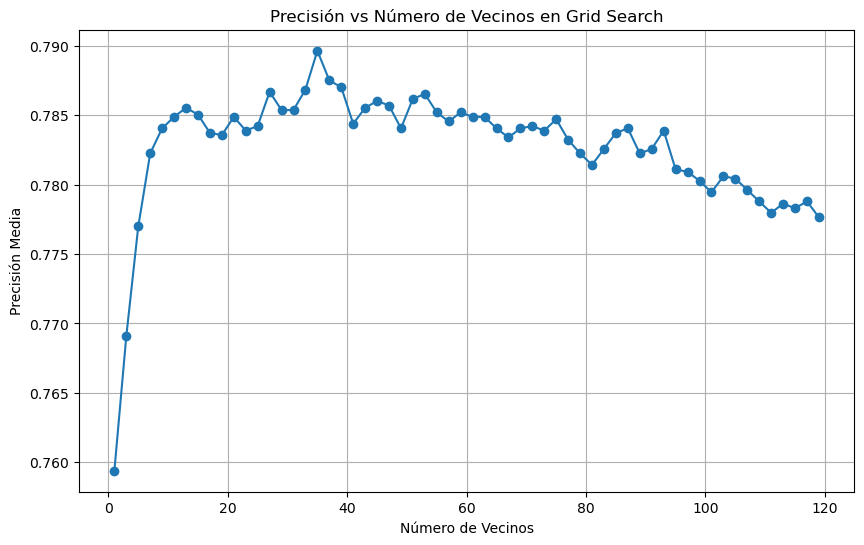

In [30]:

# Extraer los resultados del Grid Search
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Verifica los nombres de las columnas para encontrar el nombre correcto del parámetro
print(resultados_df.columns)

# Suponiendo que el nombre correcto del parámetro es 'param_knn__n_neighbors'
# Cambia 'param_knn__n_neighbors' al nombre correcto que encuentres
parametros = resultados_df['param_knn__n_neighbors']
precision_media = resultados_df['mean_test_score']

# Graficar la precisión en función del número de vecinos
plt.figure(figsize=(10, 6))
plt.plot(parametros, precision_media, marker='o')
plt.title('Precisión vs Número de Vecinos en Grid Search')
plt.xlabel('Número de Vecinos')
plt.ylabel('Precisión Media')
plt.grid(True)
plt.show()


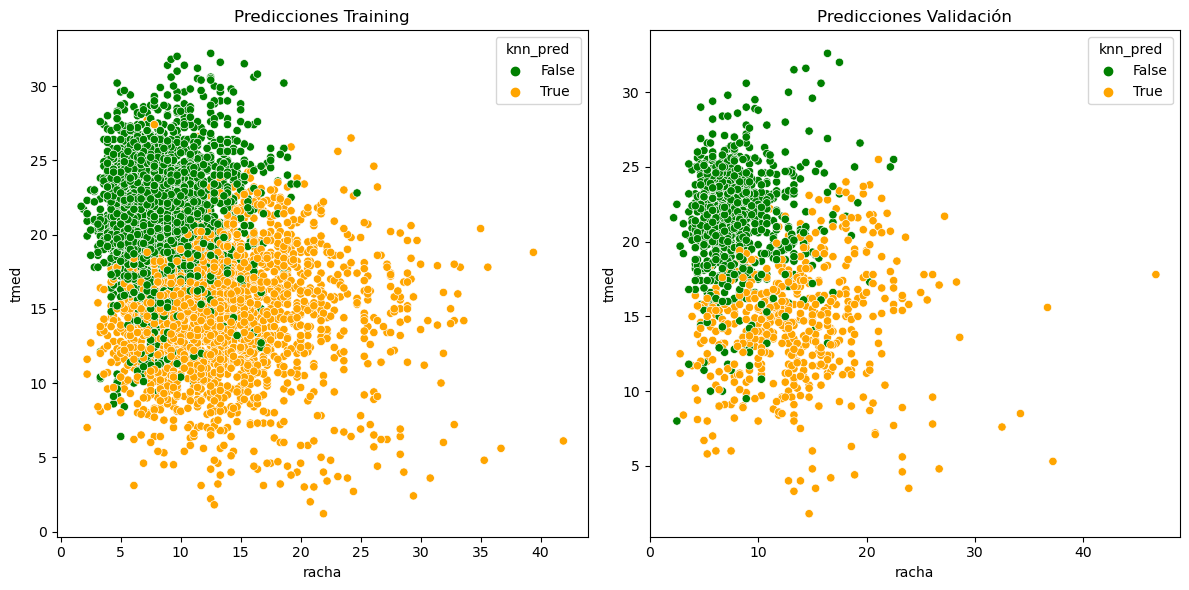

In [31]:
# Evaluación del modelo
# Training
conjunto_train_eval['knn_prob'] = best_model.predict_proba(X_train)[:, 1]
conjunto_train_eval['knn_pred'] = best_model.predict(X_train).astype(str)  # Asegúrate de que knn_pred sea de tipo str

# Test
conjunto_validation_eval['knn_prob'] = best_model.predict_proba(X_val)[:, 1]
conjunto_validation_eval['knn_pred'] = best_model.predict(X_val).astype(str)  # Asegúrate de que knn_pred sea de tipo str

# Asignar colores específicos a cada clase
# Asegúrate de que 'YES' y 'NO' correspondan a cómo se representan las clases en 'knn_pred'
palette = {'False': 'green', 'True': 'orange'}

plt.figure(figsize=(12, 6))

# Primer subplot para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
sns.scatterplot(x='racha', y='tmed', hue='knn_pred', data=conjunto_train_eval, palette=palette)
plt.title('Predicciones Training')

# Segundo subplot para el conjunto de validación
plt.subplot(1, 2, 2)
sns.scatterplot(x='racha', y='tmed', hue='knn_pred', data=conjunto_validation_eval, palette=palette)
plt.title('Predicciones Validación')

plt.tight_layout()  # Ajusta la disposición para que no haya superposición de gráficos
plt.show()

In [32]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de validación
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
confusion_mat = confusion_matrix(y_val, y_pred)

# Imprimir la matriz de confusión y la precisión en el conjunto de validación
print("Matriz de Confusión:")
print(confusion_mat)

Matriz de Confusión:
[[765 141]
 [175 439]]


In [33]:
print("Precisión en el conjunto de validación:", accuracy)
precision_val['knn_tuneGrid'] = accuracy

Precisión en el conjunto de validación: 0.7921052631578948


## K=35

In [38]:
# Método de control (k-fold cross-validation)
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [39]:
# Crear un nuevo modelo con K=35
knn_model_k35 = KNeighborsClassifier(n_neighbors=35)

# Crear un nuevo pipeline con el nuevo modelo
model_k35 = make_pipeline(StandardScaler(), knn_model_k35)

In [40]:
# Crear un imputador para reemplazar NaN con la media
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Ahora, puedes realizar la validación cruzada con X_train_imputed

# Método de control (k-fold cross-validation)
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lista para almacenar las puntuaciones de validación cruzada
cv_scores_k35 = []

# Realizar k-fold cross-validation
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_imputed, y_train), 1):
    X_train_fold, X_val_fold = X_train_imputed[train_index], X_train_imputed[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Entrenar el modelo en el conjunto de entrenamiento actual
    model_k35.fit(X_train_fold, y_train_fold)

    # Evaluar el modelo en el conjunto de validación actual
    y_val_pred = model_k35.predict(X_val_fold)
    accuracy_val_fold = accuracy_score(y_val_fold, y_val_pred)

    # Almacenar la precisión en la lista de puntuaciones de validación cruzada
    cv_scores_k35.append(accuracy_val_fold)

    # Imprimir la precisión en el fold actual
    print(f"Fold {fold}: Precisión en validación = {accuracy_val_fold}")

# Calcular y mostrar la precisión media de la validación cruzada
mean_cv_accuracy = np.mean(cv_scores_k35)
print(f"Precisión media de validación cruzada = {mean_cv_accuracy}")

Fold 1: Precisión en validación = 0.7976973684210527
Fold 2: Precisión en validación = 0.7779605263157895
Fold 3: Precisión en validación = 0.8092105263157895
Fold 4: Precisión en validación = 0.7730263157894737
Fold 5: Precisión en validación = 0.7861842105263158
Fold 6: Precisión en validación = 0.8042763157894737
Fold 7: Precisión en validación = 0.8056013179571664
Fold 8: Precisión en validación = 0.7660626029654036
Fold 9: Precisión en validación = 0.7891268533772653
Fold 10: Precisión en validación = 0.7825370675453048
Precisión media de validación cruzada = 0.7891683105003036


In [45]:
# Imputar los valores NaN en X_train
X_train_imputed = imputer.fit_transform(X_train)

# Entrenar el modelo con K=9 en el conjunto de entrenamiento
model_k35.fit(X_train_imputed, y_train)

# Evaluar el modelo en el conjunto de entrenamiento con K=35
y_train_pred_k35 = model_k35.predict(X_train_imputed)
accuracy_train_k35 = accuracy_score(y_train, y_train_pred_k35)
confusion_mat_train_k35 = confusion_matrix(y_train, y_train_pred_k35)

# Imprimir la matriz de confusión y la precisión en el conjunto de entrenamiento con K=35
print("Matriz de Confusión (Train) con K=35:")
print(confusion_mat_train_k35)
print("Precisión en el conjunto de entrenamiento con K=35:", accuracy_train_k35)

Matriz de Confusión (Train) con K=35:
[[2993  613]
 [ 627 1843]]
Precisión en el conjunto de entrenamiento con K=35: 0.7959183673469388


C:\Users\guillermo\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\guillermo\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\guillermo\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\guillermo\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


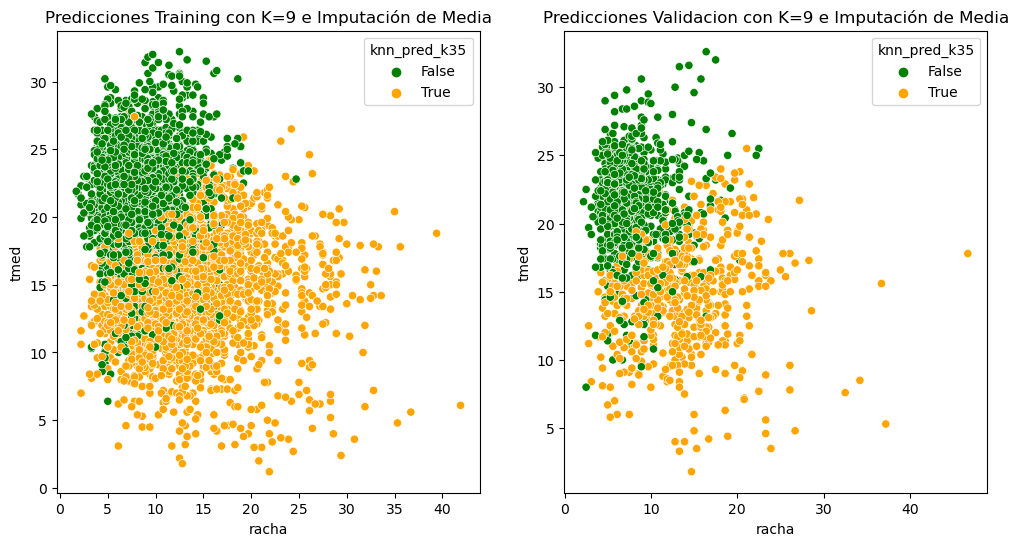

In [46]:

X_val_imputed = imputer.transform(X_val)
# Agregar probabilidades y predicciones al conjunto de entrenamiento
conjunto_train_eval['knn_prob_k35'] = best_model.predict_proba(X_train_imputed)[:, 1]
conjunto_train_eval['knn_pred_k35'] = best_model.predict(X_train_imputed)

# Agregar probabilidades y predicciones al conjunto de validación
conjunto_validation_eval['knn_prob_k35'] = best_model.predict_proba(X_val_imputed)[:, 1]
conjunto_validation_eval['knn_pred_k35'] = best_model.predict(X_val_imputed)

# Visualizar las predicciones en un gráfico de dispersión
palette = {0: 'green', 1: 'orange'}  # Asigna colores a las clases específicas

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='racha', y='tmed', hue='knn_pred_k35', data=conjunto_train_eval, palette=palette)
plt.title('Predicciones Training con K=9 e Imputación de Media')

plt.subplot(1, 2, 2)
sns.scatterplot(x='racha', y='tmed', hue='knn_pred_k35', data=conjunto_validation_eval, palette=palette)
plt.title('Predicciones Validacion con K=9 e Imputación de Media')

plt.show()



## Validacion con k=9

In [47]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Puedes crear un pipeline que primero impute los valores y luego aplique el modelo
pipeline = Pipeline(steps=[('imputer', imputer), ('classifier', KNeighborsClassifier(n_neighbors=9))])

# Entrenar el pipeline (esto también imputará los valores en el proceso)
pipeline.fit(X_train, y_train)  # Asegúrate de que X_train no tenga NaNs o también los impute antes

# Ahora puedes predecir sin preocuparte por los NaNs en X_val
y_val_pred_k35 = pipeline.predict(X_val)

# Y el resto de tu código sigue aquí
accuracy_val_k35 = accuracy_score(y_val, y_val_pred_k35)
confusion_mat_val_k35 = confusion_matrix(y_val, y_val_pred_k35)
print("Matriz de Confusión (Validation) con K=35:")
print(confusion_mat_val_k35)
print("Precisión (Validation) con K=35:", accuracy_val_k35)


Matriz de Confusión (Validation) con K=35:
[[782 124]
 [193 421]]
Precisión (Validation) con K=35: 0.7914473684210527


## CONCLUSIONES

In [48]:
# Añadir la precisión del modelo con K=9 a los diccionarios
precision_train['K=35'] = accuracy_train_k35
precision_val['K=35'] = accuracy_val_k35

# **CONCLUSIONES**

# Ordenar el diccionario de entrenamiento por sus valores de mayor a menor
precision_train_ordenada = dict(sorted(precision_train.items(), key=lambda item: item[1], reverse=True))

# Imprimir la precisión en el conjunto de entrenamiento ordenada de mayor a menor
print("Precisión en el conjunto de train (de mayor a menor):")
for nombre_modelo, valor_precision in precision_train_ordenada.items():
    print(f"{nombre_modelo}: {valor_precision}")

# Ordenar el diccionario de validación por sus valores de mayor a menor
precision_val_ordenada = dict(sorted(precision_val.items(), key=lambda item: item[1], reverse=True))

# Imprimir la precisión en el conjunto de validación ordenada de mayor a menor
print("Precisión en el conjunto de validación (de mayor a menor):")
for nombre_modelo, valor_precision in precision_val_ordenada.items():
    print(f"{nombre_modelo}: {valor_precision}")


Precisión en el conjunto de train (de mayor a menor):
knn_tuneLength_10: 0.8388742593811718
knn_tuneGrid: 0.7959183673469388
K=35: 0.7959183673469388
Precisión en el conjunto de validación (de mayor a menor):
knn_tuneGrid: 0.7921052631578948
K=35: 0.7914473684210527
knn_tuneLength_10: 0.7907894736842105


## CONCLUSIONES FINALES 
En la evaluación de nuestro modelo K-Nearest Neighbors (K-NN), la configuración knn_tuneLength_10 mostró la mayor precisión en el conjunto de entrenamiento con un 83.89%. Sin embargo, al considerar la precisión en el conjunto de validación, que es crucial para la capacidad predictiva del modelo en datos no vistos, la configuración knn_tuneGrid y K=35 ofrecieron resultados más prometedores, con precisiones de 79.21% y 79.14% respectivamente. Estas cifras son indicativas de un modelo que, aunque ligeramente menos preciso en entrenamiento, demuestra una robustez y generalización adecuadas en datos nuevos.

Por tanto, hemos decidido adoptar K=35 como el número óptimo de vecinos. Esta elección se basa en un compromiso entre alto rendimiento y generalización, asegurando que el modelo no esté sobreajustado a los datos de entrenamiento y pueda mantener una precisión consistente en la predicción de datos futuros. La coherencia entre las precisiones de entrenamiento y validación con este valor de K subraya su capacidad para ofrecer predicciones fiables y estables.